In [3]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import seaborn as sns
# from cdo import *
# cdo = Cdo()

from LinearRegression import linear_regression

data_GHCNv4   = '/work/mh0033/m301036/LSAT/Data/gistemp250_GHCNv4.nc'
data_CRUTEMP  = '/work/mh0033/m301036/LSAT/Data/CRUTEM.5.0.1.0.anomalies.nc'
data_MLOST    = '/work/mh0033/m301036/LSAT/Data/air.mon.anom.nc'
# data_NOAA     = '/work/mh0033/m301036/LSAT/Data/air.mon.anom.RG.nc'
data_Berkely  = '/work/mh0033/m301036/LSAT/Data/Complete_TAVG_LatLong1.nc'
data_GISSTEMP = '/work/mh0033/m301036/LSAT/Data/air.2x2.250.mon.anom.land.nc'

In [4]:
#Using dateTime to select key period
tas_GISS    = xr.open_dataset(data_GISSTEMP)
tas_CRUTEMP = xr.open_dataset(data_CRUTEMP) 
tas_MLOST   = xr.open_dataset(data_MLOST,decode_times=False)
units, reference_data = tas_MLOST.time.attrs['units'].split('since')
display(tas_MLOST.time)

tas_GHCNv4  = xr.open_dataset(data_GHCNv4)
tas_CRUTEMP = tas_CRUTEMP.astype(np.float64)
tas_GHCNv4  = tas_GHCNv4.astype(np.float64)
# display(tas_GISS)
# display(tas_CRUTEMP)
# display(tas_MLOST)
# display(tas_GHCNv4)

tas_CRUTEMP = tas_CRUTEMP-273.15
tas_GHCNv4  = tas_GHCNv4-273.15
# tas_MLOST_sel = tas_MLOST_sel-273.15

<xarray.DataArray 'time' (time: 2079)>
array([18262., 18293., 18321., ..., 81449., 81480., 81508.])
Coordinates:
  * time     (time) float64 1.826e+04 1.829e+04 ... 8.148e+04 8.151e+04
Attributes:
    units:                  days since 1800-1-1 00:00:0.0
    long_name:              Time
    delta_t:                0000-01-00 00:00:00
    avg_period:             0000-01-00 00:00:00
    standard_name:          time
    axis:                   T
    coordinate_defines:     start
    bounds:                 time_bnds
    calendar:               gregorian
    coverage_content_type:  coordinate
    actual_range:           [18262. 81508.]

In [5]:
# tas_MLOST.time[0].data

In [6]:
# def create_datetime(days, start_date):
#     return np.timedelta64(int(days), 'D') + np.datetime64(start_date)

# create_datetime_vec = np.vectorize(create_datetime)
# create_datetime_vec(tas_MLOST.time.data, np.repeat('1800-01-01',tas_MLOST.time.size))

In [7]:
tas_MLOST_recon = pd.to_datetime(tas_MLOST.time.data, unit='D', origin=pd.Timestamp('1800-01-01'))
tas_MLOST_recon

DatetimeIndex(['1850-01-01', '1850-02-01', '1850-03-01', '1850-04-01',
               '1850-05-01', '1850-06-01', '1850-07-01', '1850-08-01',
               '1850-09-01', '1850-10-01',
               ...
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01'],
              dtype='datetime64[ns]', length=2079, freq=None)

In [8]:
tas_MLOST = tas_MLOST.assign_coords({"time":(tas_MLOST_recon)})
tas_MLOST

<xarray.Dataset>
Dimensions:    (lat: 36, lon: 72, time: 2079, nbnds: 2)
Coordinates:
  * lat        (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon        (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    air        (time, lat, lon) float32 ...
Attributes: (12/22)
    Conventions:           CF-1.0
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    cdm_data_type:         Grid
    dataset_citation_url:  https://doi.org/10.25921/9qth-2p70
    ...                    ...
    References:            https://www.psl.noaa.gov/data/gridded/data.noaaglo...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Updated from V5.0 to V5.1 Feb 2023 using data from...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18

In [9]:
#Land only dataset
land_sea_mask=xr.open_dataset('/home/m/m301036/josie/LSAT/lsmask.nc')
display(land_sea_mask)
land_sea_mask.coords

<xarray.Dataset>
Dimensions:  (lat: 36, lon: 72, time: 1)
Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * time     (time) datetime64[ns] 2000-01-01
Data variables:
    lsmask   (time, lat, lon) float32 ...
Attributes:
    platform:       Surface
    title:          NOAA Merged Land-Ocean Surface Temperature Analysis
    Conventions:    CF-1.0
    References:     http://www.psl.noaa.gov/data/gridded/data.noaaglobaltemp....
    Source:         ftp ftp://ftp.ncdc.noaa.gov/pub/data/mlost/operational/ml...
    source:         ftp://ftp.ncdc.noaa.gov/pub/data/noaaglobaltemp/operational/
    dataset_title:  NOAA Global Surface Temperature (NOAAGlobalTemp)

Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * time     (time) datetime64[ns] 2000-01-01

In [10]:
mask_data = land_sea_mask['lsmask']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=tas_MLOST['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = tas_MLOST.where(mask_data == 1, drop=False)
masked_tas

<xarray.Dataset>
Dimensions:    (time: 2079, nbnds: 2, lat: 36, lon: 72)
Coordinates:
  * lat        (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon        (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds, lat, lon) float64 nan nan ... 9.969e+36 9.969e+36
    air        (time, lat, lon) float32 nan nan nan nan ... 6.095 6.04 5.989
Attributes: (12/22)
    Conventions:           CF-1.0
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    cdm_data_type:         Grid
    dataset_citation_url:  https://doi.org/10.25921/9qth-2p70
    ...                    ...
    References:            https://www.psl.noaa.gov/data/gridded/data.noaaglo...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Updated from V5.0 to V5.1 Feb 2023 using data from...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18

In [11]:
tas_GISS_annual    = tas_GISS['air'].loc['1900-01-01':'2014-12-01',90:0,:]
#xr.DataArray.transpose(tas_GISS['lat'], transpose_coords=True, missing_dims='raise').groupby('time.year').groups
tas_CRUTEMP_annual = tas_CRUTEMP['tas'].loc['1900-01-01':'2014-12-01',0:90,:]
tas_MLOST_annual   = tas_MLOST['air'].loc['1900-01-01':'2014-12-01',0:90,:]
tas_GHCNv4_annual  = tas_GHCNv4['tempanomaly'].loc['1900-01-01':'2014-12-01',0:90,:]

tas_GISS_ano     = tas_GISS_annual-tas_GISS_annual.mean()
tas_CRUTEMP_ano  = tas_CRUTEMP_annual-tas_CRUTEMP_annual.mean()
tas_MLOST_ano    = tas_MLOST_annual-tas_MLOST_annual.mean()
tas_GHCNv4_ano   = tas_GHCNv4_annual-tas_GHCNv4_annual.mean()

year = np.arange(1900,2015,1)
lat = tas_CRUTEMP['latitude']
lon = tas_CRUTEMP['longitude']
tas_CRUTEMP_ano

<xarray.DataArray 'tas' (time: 1379, latitude: 18, longitude: 72)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.48463036,
         0.92163036,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1900-01-16T12:00:00 ... 2014-11-16
  * latitude   (latitude) float64 2.5 7.5 12.5 17.5 22.5 ... 72.5 77.5 82.5 87.5
  * longitude  (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5

In [12]:
#Calculate the annual mean anomalies
tas_GISS_annual    = tas_GISS_ano.mean(['lat','lon']).groupby('time.year').mean()
tas_CRUTEMP_annual = tas_CRUTEMP_ano.mean(['latitude','longitude']).groupby('time.year').mean()
tas_MLOST_annual   = tas_MLOST_ano.mean(['lat','lon']).groupby('time.year').mean()
tas_GHCNv4_annual  = tas_GHCNv4_ano.mean(['lat','lon']).groupby('time.year').mean()

tas_GISS_annual
# tas_GISS_annual.to_netcdf('./GISSAnnualSATano.nc')
# tas_CRUTEMP_annual.to_netcdf('./CRUAnnualSATano.nc')
# tas_MLOST_annual.to_netcdf('./MLOSTAnnualSATano.nc')
# tas_GHCNv4_annual.to_netcdf('./GHCNAnnualSATano.nc')

<xarray.DataArray 'air' (year: 115)>
array([-0.5072481 , -0.41759214, -0.9146509 , -0.5684512 , -0.6452691 ,
       -0.50877136, -0.36003864, -0.9242468 , -0.6875146 , -0.76307774,
       -0.5454771 , -0.6169443 , -0.9383252 , -0.5939119 , -0.38501164,
       -0.52337986, -0.77478164, -1.0921775 , -0.73837596, -0.807704  ,
       -0.43177316, -0.20078582, -0.48484814, -0.34635305, -0.34581232,
       -0.24042201, -0.1594379 , -0.45128998, -0.28789905, -0.71620744,
       -0.18379383, -0.15086861, -0.16102146, -0.6072218 ,  0.07403263,
       -0.23389794, -0.183297  ,  0.15599641,  0.3849592 ,  0.04753967,
       -0.05755532, -0.3137328 , -0.13243844,  0.25877193,  0.22296105,
       -0.16112868, -0.23067833,  0.03484643, -0.03382478, -0.13152054,
       -0.364858  , -0.2168039 , -0.19342798,  0.21969427, -0.08024272,
       -0.32735586, -0.52743334, -0.22782318, -0.2142153 , -0.0273246 ,
       -0.12484312, -0.14241631, -0.03685124, -0.18519439, -0.5827289 ,
       -0.4825692 , -0.48338   , -0.13832022, -0.42721128, -0.44889832,
       -0.32414576, -0.314558  , -0.5587515 , -0.03882022, -0.4059191 ,
       -0.08224791, -0.44167534, -0.02934028, -0.26629707, -0.30872762,
       -0.03682349,  0.48227683, -0.27737552,  0.17563458, -0.0782199 ,
       -0.13971165, -0.05691729, -0.07270446,  0.30783647,  0.20720024,
        0.48613283,  0.37007037, -0.11985999,  0.10474104,  0.23690552,
        0.76001126,  0.19901066,  0.4805206 ,  0.68935275,  0.5620725 ,
        0.6089014 ,  0.7389118 ,  0.79223603,  0.8514442 ,  0.5876636 ,
        1.1271397 ,  1.0649061 ,  1.2019147 ,  0.8692868 ,  0.7817528 ,
        1.194574  ,  1.125135  ,  1.1108252 ,  0.95857733,  1.0843667 ],
      dtype=float32)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2010 2011 2012 2013 2014

In [13]:
len(np.arange(1900,2014,1))

114

In [14]:
# import pandas as pd

# time_series_GISS_annual = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GISS_annual})
# time_series_GISS_annual.to_csv('GISS_annual_NH.txt', sep='\t', index=False)

# time_series_CRUTEMP_annual = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_CRUTEMP_annual})
# time_series_CRUTEMP_annual.to_csv('CRUTEMP_annual_NH.txt', sep='\t', index=False)

# time_series_GHCNv4_annual = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GHCNv4_annual})
# time_series_GHCNv4_annual.to_csv('GHCNv4_annual_NH.txt', sep='\t', index=False)

# time_series_MLOST_annual = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_MLOST_annual})
# time_series_MLOST_annual.to_csv('MLOST_annual_NH.txt', sep='\t', index=False)

In [15]:
#Calculate the summertime anomalies
tas_GISS_JJA     = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([6,7,8])]
tas_CRUTEMP_JJA  = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([6,7,8])]
tas_MLOST_JJA    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([6,7,8])]
tas_GHCNv4_JJA   = tas_GHCNv4_ano.loc[tas_GHCNv4_ano.time.dt.month.isin([6,7,8])]

#calculate the wintertime anomalies
tas_GISS_DJF     = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([12,1,2])].loc['1900-12-01':'2014-03-01']
tas_CRUTEMP_DJF  = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([12,1,2])].loc['1900-12-01':'2014-03-01']
tas_MLOST_DJF    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([12,1,2])].loc['1900-12-01':'2014-03-01']
tas_GHCNv4_DJF   = tas_GHCNv4_ano.loc[tas_GHCNv4_ano.time.dt.month.isin([12,1,2])].loc['1900-12-01':'2014-03-01']
# tas_GHCNv4_DJF

In [16]:
#calculate annual mean for the time series of SAT
tas_GISS_JJA_mean = tas_GISS_JJA.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_GISS_JJA_mean)
tas_CRUTEMP_JJA_mean = tas_CRUTEMP_JJA.mean(['latitude','longitude']).groupby('time.year').mean()
# display(tas_CRUTEMP_JJA_mean)
tas_MLOST_JJA_mean = tas_MLOST_JJA.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_MLOST_JJA_mean)
tas_GHCNv4_JJA_mean = tas_GHCNv4_JJA.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_GHCNv4_JJA_mean)

In [17]:
# time_series_GISS_JJA = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GISS_JJA_mean})
# time_series_GISS_JJA.to_csv('GISS_JJA_NH.txt', sep='\t', index=False)

# time_series_CRUTEMP_JJA = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_CRUTEMP_JJA_mean})
# time_series_CRUTEMP_JJA.to_csv('CRUTEMP_JJA_NH.txt', sep='\t', index=False)

# time_series_GHCNv4_JJA = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GHCNv4_JJA_mean})
# time_series_GHCNv4_JJA.to_csv('GHCNv4_JJA_NH.txt', sep='\t', index=False)

# time_series_MLOST_JJA = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_MLOST_JJA_mean})
# time_series_MLOST_JJA.to_csv('MLOST_JJA_NH.txt', sep='\t', index=False)

In [18]:
#calculate DJF mean for the time series of SAT
tas_GISS_DJF_mean = tas_GISS_DJF.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_GISS_DJF_mean)
tas_CRUTEMP_DJF_mean = tas_CRUTEMP_DJF.mean(['latitude','longitude']).groupby('time.year').mean()
# display(tas_CRUTEMP_DJF_mean)
tas_MLOST_DJF_mean = tas_MLOST_DJF.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_MLOST_DJF_mean)
tas_GHCNv4_DJF_mean = tas_GHCNv4_DJF.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_GHCNv4_DJF_mean)

In [19]:
#Calculate the 15yr running trend time series
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the window size (15 years)
window_size = 15

# Calculate the number of data points in the window
num_points  = len(tas_GISS_annual)
num_windows = num_points - window_size + 1

# Initialize an array to store the trend values
trend = np.zeros(num_windows)
for i in range(num_windows):
    GISS_window_data = tas_GISS_annual[i:i+window_size]
    time = np.arange(len(GISS_window_data))
    trend[i] = np.polyfit(time, GISS_window_data, 1)[0]

print(trend)
print(len(trend))

trend1 = np.zeros(num_windows)
for i in range(num_windows):
    MLOST_window_data = tas_MLOST_annual[i:i+window_size]
    time = np.arange(len(MLOST_window_data))
    trend1[i] = np.polyfit(time, MLOST_window_data, 1)[0]

print(trend1)
print(len(trend1))

[-0.00375471  0.0021556   0.00440007 -0.01421635 -0.01346229 -0.01602935
 -0.00471808  0.01634239  0.0136123   0.01953909  0.02210201  0.03202662
  0.04084443  0.03154968  0.03444066  0.03149962  0.03909837  0.03912455
  0.02760018  0.01170387  0.01038971  0.00896911  0.01470647  0.02074764
  0.03418115  0.0365828   0.03796339  0.03460028  0.02798195  0.03467344
  0.02627988  0.02014172  0.01312459  0.01274053 -0.00280841 -0.00338319
 -0.0178553  -0.0267126  -0.02517173 -0.00551308 -0.00240317 -0.00801744
 -0.02498943 -0.02852811 -0.0202085  -0.00655055 -0.00541067 -0.00682685
  0.0016673   0.0047469  -0.00436257 -0.01602337 -0.02305392 -0.01983804
 -0.01223776 -0.0114389  -0.01326498 -0.02057933 -0.02619849 -0.01724869
 -0.01276304 -0.00161973 -0.00011632  0.01578039  0.02148799  0.01506634
  0.01732542  0.0309469   0.03198715  0.03659524  0.03208432  0.02827662
  0.02615402  0.01573963  0.02795807  0.025934    0.03794128  0.03474771
  0.0281878   0.020796    0.01417087  0.02644339  0

In [20]:
trend2 = np.zeros(num_windows)
for i in range(num_windows):
    CRUTEMP_window_data = tas_CRUTEMP_annual[i:i+window_size]
    time = np.arange(len(CRUTEMP_window_data))
    trend2[i] = np.polyfit(time, CRUTEMP_window_data, 1)[0]

print(trend2)
print(len(trend2))

[-0.00042244  0.00667663  0.01232981 -0.00320628 -0.0034918  -0.00799823
  0.00011871  0.01852546  0.01401676  0.01541993  0.01505782  0.02346134
  0.02914373  0.02061247  0.0220871   0.01859533  0.02701825  0.02915428
  0.01919581  0.00562265  0.00633414  0.00652649  0.01282935  0.01634863
  0.02691147  0.02793436  0.02790204  0.02530802  0.01936909  0.02504872
  0.01774493  0.01263661  0.00852548  0.00772661 -0.00291735 -0.00141695
 -0.01373145 -0.01932933 -0.02053484 -0.00199703  0.00091645 -0.00560535
 -0.0212251  -0.0246462  -0.01683226 -0.00366274 -0.00427548 -0.00330407
  0.00343795  0.00984629  0.00256586 -0.01029452 -0.01573385 -0.01375056
 -0.00587637 -0.00842073 -0.01083771 -0.02033369 -0.02633711 -0.0178039
 -0.01448644 -0.00495578 -0.00432099  0.01071679  0.01795986  0.01317155
  0.01421202  0.0265301   0.02882361  0.03535204  0.02895941  0.02384919
  0.02252867  0.0137251   0.02650941  0.02588736  0.03942351  0.03606382
  0.03079858  0.02358663  0.01813007  0.02889608  0.

In [21]:
#Calculate JJA and DJF trend
trend_JJA = np.zeros(num_windows)
for i in range(num_windows):
    GISS_window_jja = tas_GISS_JJA_mean[i:i+window_size]
    time = np.arange(len(GISS_window_jja))
    trend_JJA[i] = np.polyfit(time, GISS_window_jja, 1)[0]

print(trend_JJA)
print(len(trend_JJA))

trend_DJF = np.zeros(num_windows)
for i in range(num_windows):
    GISS_window_djf = tas_GISS_DJF_mean[i:i+window_size]
    time = np.arange(len(GISS_window_djf))
    trend_DJF[i] = np.polyfit(time, GISS_window_djf, 1)[0]

print(trend_DJF)
print(len(trend_DJF))

[-0.01145921 -0.00237529  0.00811387  0.00312672 -0.00494979 -0.00739134
 -0.00017834  0.01750074  0.01474877  0.01563877  0.01790543  0.01939429
  0.02256061  0.01796694  0.00927477  0.00466611  0.01513197  0.02026738
  0.01873972  0.00987143  0.00693566  0.00854998  0.02121564  0.02794009
  0.03019313  0.03061892  0.02860422  0.02481652  0.0227051   0.01591816
  0.00208983  0.00271728  0.0024643  -0.00327974 -0.00885322 -0.02113716
 -0.03029309 -0.02543644 -0.01723483 -0.0038857   0.00237202  0.00476667
  0.00040573  0.0034643   0.00494699  0.00798711  0.01549153  0.01530019
  0.00896331  0.00662116 -0.00768727 -0.02308657 -0.02187095 -0.02062175
 -0.01759841 -0.0137124  -0.01068043 -0.01722879 -0.01599489 -0.0084684
 -0.00341974  0.00785211  0.00929829  0.01636906  0.01084211  0.00837841
  0.00576246  0.01738907  0.01504375  0.01627916  0.01836257  0.01574561
  0.01245167  0.00916154  0.02540047  0.02868283  0.03958872  0.04086694
  0.02952411  0.01849523  0.0189888   0.02598628  0.

In [22]:
trend1_JJA = np.zeros(num_windows)
for i in range(num_windows):
    MLOST_window_jja = tas_MLOST_JJA_mean[i:i+window_size]
    time = np.arange(len(MLOST_window_jja))
    trend1_JJA[i] = np.polyfit(time, MLOST_window_jja, 1)[0]

print(trend1_JJA)
print(len(trend1_JJA))

trend1_DJF = np.zeros(num_windows)
for i in range(num_windows):
    MLOST_window_djf = tas_MLOST_DJF_mean[i:i+window_size]
    time = np.arange(len(MLOST_window_djf))
    trend1_DJF[i] = np.polyfit(time, MLOST_window_djf, 1)[0]

print(trend1_DJF)
print(len(trend1_DJF))

[-0.01732331 -0.0057025   0.00186787  0.00081576 -0.00306703  0.00060601
  0.00842912  0.01639924  0.02163039  0.02538443  0.02682317  0.02488271
  0.02157055  0.02050476  0.01701192  0.010745    0.0202388   0.02529684
  0.02327658  0.01371157  0.01182625  0.0119169   0.0223932   0.0308585
  0.03323065  0.03088188  0.02856703  0.02678542  0.02047725  0.01633982
  0.00610684  0.003897    0.00104649 -0.00506951 -0.0145127  -0.02432793
 -0.03256784 -0.02070588 -0.01189281  0.00037225  0.00212411  0.00366564
  0.00167056  0.0053228   0.00982594  0.01354165  0.01950069  0.01470047
  0.00905291  0.00489663 -0.00800636 -0.02315664 -0.01931409 -0.01768922
 -0.01096478 -0.00812248 -0.01014412 -0.01787911 -0.01878445 -0.01271665
 -0.01016134 -0.00377709 -0.00218304  0.00442618 -0.00043679  0.00359236
  0.00295041  0.0163274   0.01730271  0.02221858  0.02421022  0.02018083
  0.01893866  0.01571616  0.0257946   0.02391381  0.0269661   0.02895687
  0.02087437  0.00978876  0.01137424  0.01817919  0.

In [23]:
trend2_JJA = np.zeros(num_windows)
for i in range(num_windows):
    CRUTEMP_window_jja = tas_CRUTEMP_JJA_mean[i:i+window_size]
    time = np.arange(len(CRUTEMP_window_jja))
    trend2_JJA[i] = np.polyfit(time, CRUTEMP_window_jja, 1)[0]

print(trend2_JJA)
print(len(trend2_JJA))

trend2_DJF = np.zeros(num_windows)
for i in range(num_windows):
    CRUTEMP_window_djf = tas_CRUTEMP_DJF_mean[i:i+window_size]
    time = np.arange(len(CRUTEMP_window_djf))
    trend2_DJF[i] = np.polyfit(time, CRUTEMP_window_djf, 1)[0]

print(trend2_DJF)
print(len(trend2_DJF))

[-8.48596199e-03 -1.48418516e-03  1.31153490e-02  1.18268990e-02
  1.77046462e-03 -6.95364403e-04  7.88297510e-03  2.27915038e-02
  1.79783028e-02  1.42222243e-02  1.47779631e-02  1.65981260e-02
  1.93961792e-02  1.73149033e-02  6.89309608e-03  4.16682533e-03
  1.16888374e-02  1.79887776e-02  1.93068303e-02  1.33432326e-02
  1.23728802e-02  1.45668016e-02  2.58586457e-02  3.24162061e-02
  3.09139304e-02  3.01237396e-02  2.76531757e-02  2.28056047e-02
  1.96067908e-02  8.47530477e-03 -4.60862656e-03 -5.08227448e-03
 -5.54694866e-03 -1.05688841e-02 -1.28901608e-02 -2.33512922e-02
 -3.19959100e-02 -2.68240630e-02 -1.78297369e-02 -4.00524284e-03
  1.51912400e-03  3.84246589e-03 -5.64864748e-04  7.81597327e-04
  8.05222557e-05  3.44270840e-03  8.76244973e-03  8.67045881e-03
  4.08765534e-03  3.93377262e-03 -7.80268283e-03 -2.23877047e-02
 -2.08041569e-02 -1.89499718e-02 -1.56451530e-02 -1.33577155e-02
 -9.74945302e-03 -1.78940287e-02 -1.62114910e-02 -1.02604305e-02
 -4.90498849e-03  3.81128

In [24]:
# time_series_GISS_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GISS_DJF_mean})
# time_series_GISS_DJF.to_csv('GISS_DJF_NH.txt', sep='\t', index=False)

# time_series_CRUTEMP_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_CRUTEMP_DJF_mean})
# time_series_CRUTEMP_DJF.to_csv('CRUTEMP_DJF_NH.txt', sep='\t', index=False)

# time_series_GHCNv4_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GHCNv4_DJF_mean})
# time_series_GHCNv4_DJF.to_csv('GHCNv4_DJF_NH.txt', sep='\t', index=False)

# time_series_MLOST_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_MLOST_DJF_mean})
# time_series_MLOST_DJF.to_csv('MLOST_DJF_NH.txt', sep='\t', index=False)

In [25]:
out_dir = "/home/m/m301036/josie/LSAT/output_text/"
trend_GISS_annual = pd.DataFrame({'time': np.arange(1906,2007,1), 'values': trend})
trend_GISS_annual.to_csv(out_dir+'GISS_annual_NH_trend.txt', sep='\t', index=False)

trend_GISS_JJA = pd.DataFrame({'time': np.arange(1906,2007,1), 'values': trend_JJA})
trend_GISS_JJA.to_csv(out_dir+'GISS_JJA_NH_trend.txt', sep='\t', index=False)

trend_GISS_DJF = pd.DataFrame({'time': np.arange(1906,2007,1), 'values': trend_DJF})
trend_GISS_DJF.to_csv(out_dir+'GISS_DJF_NH_trend.txt', sep='\t', index=False)

In [26]:
trend_MLOST_annual = pd.DataFrame({'time': np.arange(1906,2007,1), 'values': trend1})
trend_MLOST_annual.to_csv(out_dir+'MLOST_annual_NH_trend.txt', sep='\t', index=False)

trend_MLOST_JJA = pd.DataFrame({'time': np.arange(1906,2007,1), 'values': trend1_JJA})
trend_MLOST_JJA.to_csv(out_dir+'MLOST_JJA_NH_trend.txt', sep='\t', index=False)

trend_MLOST_DJF = pd.DataFrame({'time': np.arange(1906,2007,1), 'values': trend1_DJF})
trend_MLOST_DJF.to_csv(out_dir+'MLOST_DJF_NH_trend.txt', sep='\t', index=False)

In [27]:
trend_CRUTEMP_annual = pd.DataFrame({'time': np.arange(1906,2007,1), 'values': trend2})
trend_CRUTEMP_annual.to_csv(out_dir+'CRUTEMP_annual_NH_trend.txt', sep='\t', index=False)

trend_CRUTEMP_JJA = pd.DataFrame({'time': np.arange(1906,2007,1), 'values': trend2_JJA})
trend_CRUTEMP_JJA.to_csv(out_dir+'CRUTEMP_JJA_NH_trend.txt', sep='\t', index=False)

trend_CRUTEMP_DJF = pd.DataFrame({'time': np.arange(1906,2007,1), 'values': trend2_DJF})
trend_CRUTEMP_DJF.to_csv(out_dir+'CRUTEMP_DJF_NH_trend.txt', sep='\t', index=False)

In [28]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<function matplotlib.pyplot.show(close=None, block=None)>

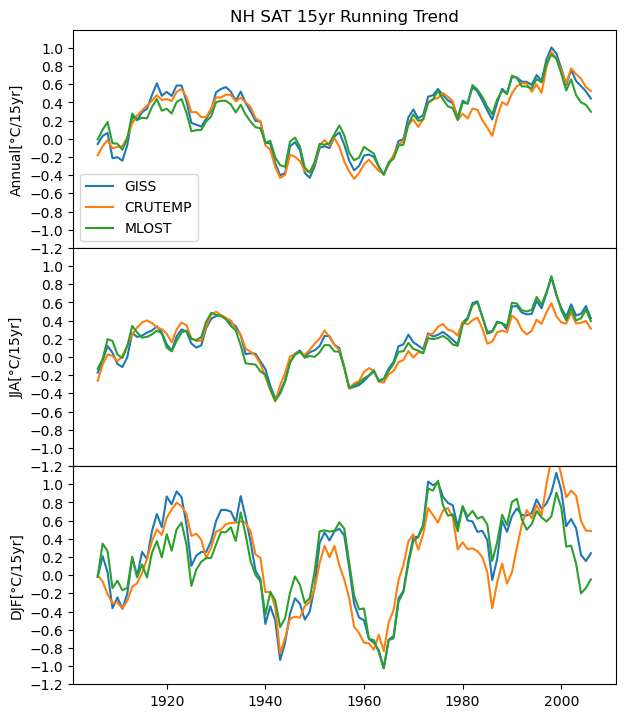

In [30]:
fig,axs = plt.subplots(3,1, figsize=(7,8.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
# plt.style.use('seaborn-bright')
x = np.arange(1906,2007,1)

axs[0].plot(x, trend*15.0, label='GISS')
axs[0].plot(x, trend1*15.0, label= 'CRUTEMP')
axs[0].plot(x, trend2*15.0, label='MLOST')

axs[0].set_ylabel("Annual[°C/15yr]")
axs[0].set_title('NH SAT 15yr Running Trend')

axs[1].plot(x, trend_JJA*15.0)
axs[1].plot(x, trend1_JJA*15.0)
axs[1].plot(x, trend2_JJA*15.0)
# axs[1].plot(x, tas_GHCNv4_JJA_mean)
axs[1].set_ylabel("JJA[°C/15yr]")
# axs[1].set_title('1900-2014 JJA NH SAT')

axs[0].set_yticks(np.arange(-1.2,1.2, 0.2))
axs[0].set_ylim(-1.2,1.2)

axs[2].plot(x, trend_DJF*15.0)
axs[2].plot(x, trend1_DJF*15.0)
axs[2].plot(x, trend2_DJF*15.0)
# axs[2].plot(x, tas_GHCNv4_DJF_mean)
axs[2].set_ylabel("DJF[°C/15yr]")

# axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 0.95, 0.15, 0.15))
axs[0].legend()

# axs[2].set_title('1900-2014 DJF NH SAT')

# Temperature vs time plot - illustrates the "x" and "add_legend" kwargs
# air.isel(lon=30, lat=isel_lats).plot.line(ax=ax2, x="time", add_legend=False)
# ax2.set_ylabel("")
# sns.set_context('poster')

# fig.savefig("Obs_NH_15yr_SAT_trend.png")
fig.savefig('/home/m/m301036/josie/LSAT/output-Figures/Obs_NH_15yr_SAT_trend.eps', format='eps')
plt.show
# fig.tight_layout()


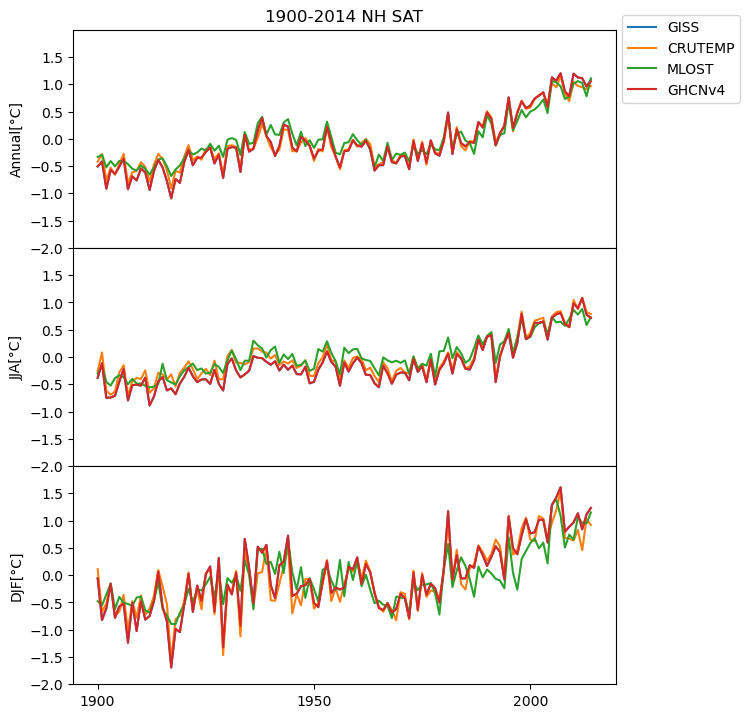

In [14]:
#Plot the annual mean temperature anomalies
# import proplot as pplt
# fig= pplt.figure(share=False, suptitle='Northern Hemisphere mean LSAT anomaly')
# axs = fig.subplots
# Prepare the figure
# fig = plt.figure()
# axs = fig.add_subplot(1,1,1)
fig,axs = plt.subplots(3,1, figsize=(7,8.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)

axs[0].plot(year, tas_GISS_annual, label='GISS')
axs[0].plot(year, tas_CRUTEMP_annual, label= 'CRUTEMP')
axs[0].plot(year, tas_MLOST_annual, label='MLOST')
axs[0].plot(year, tas_GHCNv4_annual, label='GHCNv4')

axs[0].set_ylabel("Annual[°C]")
axs[0].set_title('1900-2014 NH SAT')

axs[1].plot(year, tas_GISS_JJA_mean)
axs[1].plot(year, tas_CRUTEMP_JJA_mean)
axs[1].plot(year, tas_MLOST_JJA_mean)
axs[1].plot(year, tas_GHCNv4_JJA_mean)

axs[1].set_ylabel("JJA[°C]")
# axs[1].set_title('1900-2014 JJA NH SAT')

axs[0].set_yticks(np.arange(-2.0,2.0, 0.5))
axs[0].set_ylim(-2.0,2.0)

axs[2].plot(year, tas_GISS_DJF_mean)
axs[2].plot(year, tas_CRUTEMP_DJF_mean)
axs[2].plot(year, tas_MLOST_DJF_mean)
axs[2].plot(year, tas_GHCNv4_DJF_mean)
axs[2].set_ylabel("DJF[°C]")

axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 0.95, 0.15, 0.15))
# axs[2].set_title('1900-2014 DJF NH SAT')

# Temperature vs time plot - illustrates the "x" and "add_legend" kwargs
# air.isel(lon=30, lat=isel_lats).plot.line(ax=ax2, x="time", add_legend=False)
# ax2.set_ylabel("")
sns.set_context('poster')
# Show
plt.show
# fig.tight_layout()
# plt.savefig(fig, format='eps')
fig.savefig("NH_averaged_SAT_TS_1900-2014.png")